# Import Libraries

In [1]:
import keras
import gc
import tensorflow as tf
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [2]:
# Set random seeds
np.random.seed(0)
tf.set_random_seed(0)

# Open Data

In [3]:
# Open data, csv files should be in same folder as notebook.
notebook_dir = %pwd

items = pd.read_csv(notebook_dir + "/items.csv")
shops = pd.read_csv(notebook_dir + "/shops.csv")
train = pd.read_csv(notebook_dir + "/sales_train.csv")
test = pd.read_csv(notebook_dir + "/test.csv")
sample_submission = pd.read_csv(notebook_dir + "/sample_submission.csv")
item_category = pd.read_csv(notebook_dir + "/item_categories.csv")

# Exploratory Data Analysis
## Additional Data

In [4]:
print('Amount of items:', len(items))
items.head()

Amount of items: 22170


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
print('Amount of shops:', len(shops))
shops.head()

Amount of shops: 60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
print('Amount of item categories:', len(item_category))
item_category.head()

Amount of item categories: 84


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
print('Amount of item submissions:', len(sample_submission))
sample_submission.head()

Amount of item submissions: 214200


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## Train

In [8]:
print('Size of train-set:', len(train))
train.head()

Size of train-set: 2935849


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


As we can see price and item count vary by quite a lot and are in some cases invalid (negative price)

In [10]:
# Drop duplicates so they cannot influence training
train.drop_duplicates(inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb7f3f10cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb7f3f27390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb7f3f10b38>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb7f3f27a20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7f3f27d68>],
 'means': []}

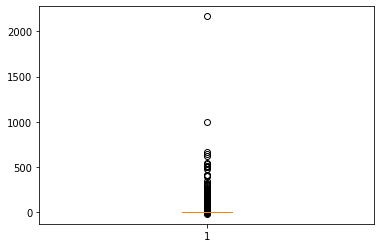

In [11]:
plt.boxplot(train['item_cnt_day'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb7f3ea9a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb7f3eb5160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb7f3ea9748>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb7f3eb57f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb7f3eb5b38>],
 'means': []}

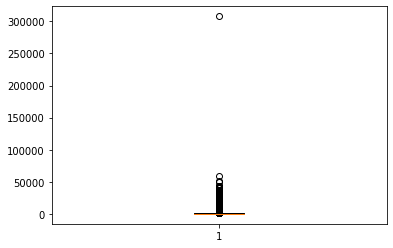

In [12]:
plt.boxplot(train['item_price'])

(array([ 7.,  0.,  4.,  6.,  8.,  4.,  1.,  2.,  1.,  1.]),
 array([  50588. ,   59853.8,   69119.6,   78385.4,   87651.2,   96917. ,
         106182.8,  115448.6,  124714.4,  133980.2,  143246. ]),
 <a list of 10 Patch objects>)

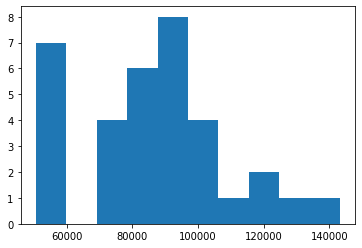

In [13]:
plt.hist(train.groupby(by=['date_block_num'])['item_cnt_day'].count())

The item count has quite a few outliers. The amount of rows for each month is also vastly different. Both of these findings can influence training.

## Test

In [14]:
print('Size of test-set:', len(test))
test.head()

Size of test-set: 214200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


as we can see test does not have many features. We will have to create those.

In [15]:
train['shop_id'].nunique() - test['shop_id'].nunique(), \
train['item_id'].nunique() - test['item_id'].nunique(), \
len(list(set(test['item_id']) - set(train['item_id']))), \
len(list(set(test['shop_id']) - set(train['shop_id'])))

(18, 16707, 363, 0)

We can see that some shops and many items do not appear in the test set but do in the train set. These will not be necessary for training.

Also 363 items that appear in the test set never appear in the train set. Since training on the test dataframe will almost never give output as 0, we should make sure the distribution between train and test is similar to improve training performance. We can do this by adding rows with 0 sales as values.

# Data Leakages
During EDA we discovered that many items and shops are not being asked for in the test set. We remove these from the train set.

In [16]:
before_size = len(train)
train = train[train['shop_id'].isin(test['shop_id'].unique())]
train = train[train['item_id'].isin(test['item_id'].unique())]
after_size = len(train)
print(f'before size: {before_size}', '\n', f'after size: {after_size}')

before size: 2935843 
 after size: 1224434


# Data Preprocessing and Generation
We are dealing with a 1 month future prediction problem. If we teach the model to predict sales 1 month into the future, then we can use all features provided in the training set instead of being limited to the test sets features.

In [17]:
train_data = train.drop(columns=['date']) \
.groupby(by=['date_block_num', 'shop_id', 'item_id'], as_index=False) \
.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean', 'count']})

# Rename columns
train_data.columns = ['date_block_num', 'shop_id', 'item_id', \
                      'summed_item_price', 'mean_item_price', \
                      'total_item_cnt', 'mean_item_cnt', 'transactions']

## Add Missing Combinations
We add the missing product shop month combos to make the distribution train/test similar

In [18]:
# Build empty DataFrame
shop_ids = train_data['shop_id'].unique()
item_ids = train_data['item_id'].unique()  

# Extend later with item ids in test
item_ids = np.concatenate([item_ids, np.array(list(set(test['item_id']) - set(train['item_id'])))])
item_ids.sort()

empty_df = []
for month_block in range(34):
    for shop_id in shop_ids:
        for item_id in item_ids:
            empty_df.append([month_block, shop_id, item_id])

empty_df = pd.DataFrame(empty_df, columns=['date_block_num', 'shop_id', 'item_id'])

In [19]:
# Merge train_data into empty_df and fill NaNs with 0
train_data = pd.merge(empty_df, train_data, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

## Clean Data

In [20]:
# Remove price outliers
train_data = train_data[train_data['summed_item_price'] >= 0]
train_data = train_data[train_data['summed_item_price'] < 400000]

In [21]:
# Remove count outliers
train_data = train_data[train_data['total_item_cnt'] >= 0]
train_data = train_data[train_data['total_item_cnt'] <= 20]

# Or Clip them
# train_data['item_cnt_day'] = train_data['item_cnt_day'].clip(0, 20)

## Target

In [22]:
train_data['target'] = train_data.sort_values('date_block_num')\
.groupby(['shop_id', 'item_id'])['total_item_cnt']\
.shift(-1)

## Basic Features

### Month

In [23]:
train_data['month'] = train_data['date_block_num'] % 12

### Year

In [24]:
train_data['year'] = train_data['date_block_num'] // 12 + 2013

### Days in Month

In [25]:
days_in_month = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_data['days_in_month'] = train_data['month'].map(days_in_month).astype(np.int8)

### Item Category

In [26]:
item_category_map = items[['item_id', 'item_category_id']]
train_data = pd.merge(train_data, item_category_map, on=['item_id'])

### Unit Price

In [27]:
train_data['unit_item_price'] = (train_data['summed_item_price'] // train_data['total_item_cnt']).fillna(0).replace(np.inf, 0)

### Month Shop Sales

In [28]:
month_shop_sales = train_data.groupby(['date_block_num', 'shop_id'], as_index=False)['total_item_cnt'].sum().rename(columns={'total_item_cnt': 'month_shop_sales'})
train_data = pd.merge(train_data, month_shop_sales, on=['date_block_num', 'shop_id'], how='left').fillna(0)

### Month Item Sales

In [29]:
month_item_sales = train_data.groupby(['date_block_num', 'item_id'], as_index=False)['total_item_cnt'].sum().rename(columns={'total_item_cnt': 'month_item_sales'})
train_data = pd.merge(train_data, month_item_sales, on=['date_block_num', 'item_id'], how='left').fillna(0)

## Historical Features
### Historical Prices

In [30]:
historical_prices = train_data.groupby(by=['item_id'], as_index=False) \
.agg({'summed_item_price': [np.min, np.max]})

historical_prices.columns = ['item_id', 'hist_min_price', 'hist_max_price']
train_data = pd.merge(train_data, historical_prices, on='item_id', how='left').fillna(0)

### Change from Historical Prices

In [31]:
train_data['price_increase'] = train_data['summed_item_price'] - train_data['hist_min_price']
train_data['price_decrease'] = train_data['summed_item_price'] - train_data['hist_max_price']

## Downcast types

In [32]:
train_data['date_block_num'] = train_data['date_block_num'].astype(np.int8)
train_data['shop_id'] = train_data['shop_id'].astype(np.int16)
train_data['item_id'] = train_data['item_id'].astype(np.int16)
train_data['summed_item_price'] = train_data['summed_item_price'].astype(np.float32)
train_data['mean_item_price'] = train_data['mean_item_price'].astype(np.float32)
train_data['unit_item_price'] = train_data['unit_item_price'].astype(np.int32)
train_data['hist_min_price'] = train_data['hist_min_price'].astype(np.float32)
train_data['hist_max_price'] = train_data['hist_max_price'].astype(np.float32)
train_data['price_increase'] = train_data['price_increase'].astype(np.float32)
train_data['price_decrease'] = train_data['price_decrease'].astype(np.float32)
train_data['total_item_cnt'] = train_data['total_item_cnt'].astype(np.int32)
train_data['mean_item_cnt'] = train_data['total_item_cnt'].astype(np.float32)
train_data['transactions'] = train_data['transactions'].astype(np.int32)
train_data['month'] = train_data['month'].astype(np.int8)
train_data['year'] = train_data['year'].astype(np.int16)
train_data['item_category_id'] = train_data['item_category_id'].astype(np.int16)
train_data['month_shop_sales'] = train_data['month_shop_sales'].astype(np.int32)
train_data['month_item_sales'] = train_data['month_item_sales'].astype(np.int32)

## Lag Based Features
### Sale Lags

In [33]:
lags = [1, 2, 3, 6, 12]

def add_lag_features(train_data, grouped_data, lags, old_name, new_name, merge_list):
    for lag in lags:
        lag_series = grouped_data.copy()
        composed_name = f'{new_name}_lag{lag}m'
        lag_series['date_block_num'] += lag
        lag_series.rename(columns={old_name: composed_name}, inplace=True)
        
        train_data = pd.merge(train_data, lag_series, on=merge_list, how='left').fillna(0)
        train_data[composed_name] = train_data[composed_name].astype(train_data[old_name].dtype)
        
        del lag_series
        gc.collect()
    return train_data

In [34]:
# Month Shop Item Sales
month_shop_item = train_data[['date_block_num', 'shop_id', 'item_id', 'total_item_cnt']]
train_data = add_lag_features(train_data, month_shop_item, lags, 'total_item_cnt', 'month_shop_item_sales', ['date_block_num', 'shop_id', 'item_id'])

# Month Shop Sales
month_shop = train_data.groupby(['date_block_num', 'shop_id'], as_index=False)['month_shop_sales'].mean()
train_data = add_lag_features(train_data, month_shop, lags, 'month_shop_sales', 'month_shop_sales', ['date_block_num', 'shop_id'])

# Month Item Sales
month_item = train_data.groupby(['date_block_num', 'item_id'], as_index=False)['month_item_sales'].mean()
train_data = add_lag_features(train_data, month_item, lags, 'month_item_sales', 'month_item_sales', ['date_block_num', 'item_id'])

### Sales Count Trend

In [35]:
def add_trend(train_data, total_count, lags, base_feat_name, new_name):
    train_data[new_name] = total_count
    for lag in lags:
        composed_name = f'{base_feat_name}_lag{lag}m'
        train_data[new_name] -= train_data[composed_name]
    
    train_data[new_name] /= len(lags) + 1
    train_data[new_name] = train_data[new_name].astype(np.float32)
    return train_data

In [36]:
# Trend Shop Item Sales
train_data = add_trend(train_data, train_data['total_item_cnt'], lags, 'month_shop_item_sales', 'shop_item_trend')

# Trend Shop Sales
train_data = add_trend(train_data, train_data['month_shop_sales'], lags, 'month_shop_sales', 'shop_trend')

# Trend Item Sales
train_data = add_trend(train_data, train_data['month_item_sales'], lags, 'month_item_sales', 'item_trend')

Remove the first max(lag) months of train dataset as these have no lag values.

In [37]:
train_data = train_data[train_data['date_block_num'] >= max(lags)]

## Result

In [38]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,4708036.0,22.499862,6.344737,12.000000,17.000000,22.000000,28.000000,33.000000
shop_id,4708036.0,31.643266,17.563453,2.000000,16.000000,35.000000,47.000000,59.000000
item_id,4708036.0,11019.941696,6251.749247,30.000000,5382.000000,11207.000000,16071.000000,22167.000000
summed_item_price,4708036.0,201.474991,2062.762939,0.000000,0.000000,0.000000,0.000000,366860.000000
mean_item_price,4708036.0,96.350044,605.202209,0.000000,0.000000,0.000000,0.000000,42990.000000
total_item_cnt,4708036.0,0.204145,0.929529,0.000000,0.000000,0.000000,0.000000,20.000000
mean_item_cnt,4708036.0,0.204145,0.929529,0.000000,0.000000,0.000000,0.000000,20.000000
transactions,4708036.0,0.185371,0.762452,0.000000,0.000000,0.000000,0.000000,18.000000
target,4708036.0,0.196718,0.908252,0.000000,0.000000,0.000000,0.000000,20.000000
month,4708036.0,5.044846,3.239628,0.000000,2.000000,5.000000,8.000000,11.000000


### Memory Cleanup

In [39]:
del month_item
del month_shop
del month_shop_item
del historical_prices
del month_item_sales
del month_shop_sales
del item_category_map
del days_in_month
del empty_df
del train
gc.collect()

0

# Validation
The Train/Test split is a time based split. The test data is the month (date_block_num 34) directly after the data in the train data (date_block_num 12 - 33). We will be using ensembling later so our validation set will be used to train the 2nd layer model. Hence for training we will use a time based split as well by using block 12 - 28 as training and using 29-32 as validation.

After submitting the csv a few times and observing the loss for the public and private leaderboard to be almost identical we take these are both randomly sampled from the test set.

### Train Validation Split

In [40]:
X = train_data.drop(columns=['target'])
y = train_data['target']

#del train_data
#gc.collect()

In [41]:
X_train = X[X['date_block_num'] < 32]
y_train = y[X['date_block_num'] < 32]
X_val = X[X['date_block_num'] == 32]
y_val = y[X['date_block_num'] == 32]

# Training

In [42]:
def print_prediciton_scores(model_name, y, preds, pred_type):
    print(f'{pred_type} R-squared for {model_name}: {r2_score(y, preds)}' )
    print(f'{pred_type} RMSE for {model_name}: {np.sqrt(mean_squared_error(y, preds))}')
    print(f'{pred_type} Accuracy Score for {model_name}: {accuracy_score(y, np.around(preds))}')

## Linear Regression

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
train_pred_lr = lr.predict(X_train.values)
pred_lr = lr.predict(X_val.values)
print_prediciton_scores('LR', y_train, train_pred_lr, 'Train')
print_prediciton_scores('LR', y_val, pred_lr, 'Validation')

Train R-squared for LR: 0.3836095150232868
Train RMSE for LR: 0.7301686075695035
Train Accuracy Score for LR: 0.8825015373630626
Validation R-squared for LR: 0.2617381385061095
Validation RMSE for LR: 0.772314298574841
Validation Accuracy Score for LR: 0.835390446458198


## XGBoost

In [45]:
colsample_bytree = 0.5
subsample = 0.8
min_child_weight = 3
learning_rate = 0.01
max_depth = 10
alpha = 500
n_estimators = 1000

xgb_reg = xgb.XGBRegressor(tree_method = 'gpu_hist', objective = 'reg:squarederror', 
                          colsample_bytree = colsample_bytree, learning_rate = learning_rate, max_depth = max_depth, 
                          alpha = alpha, n_estimators = n_estimators, min_child_weight = min_child_weight,
                          subsample = subsample)

xgb_reg.fit(X_train, y_train)

/home/dustin/anaconda3/envs/coursera-aml/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(alpha=500, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, tree_method='gpu_hist',
       verbosity=1)

In [46]:
train_pred_xgb = xgb_reg.predict(X_train)
pred_xgb = xgb_reg.predict(X_val)
print_prediciton_scores('XGB', y_train, train_pred_xgb, 'Train')
print_prediciton_scores('XGB', y_val, pred_xgb, 'Validation')

Train R-squared for XGB: 0.5936029392393498
Train RMSE for XGB: 0.5928850143572767
Train Accuracy Score for XGB: 0.8881946871723174
Validation R-squared for XGB: 0.3345956828833495
Validation RMSE for XGB: 0.7332155482044783
Validation Accuracy Score for XGB: 0.8449290331023073


## Random Forest
We use Random forest to plot accuracy against amount of trees to get an idea how good our features work with tree besed classifiers.

In [47]:
rf = RandomForestClassifier(n_estimators=100, max_depth=7, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
# train_pred_rf = rf.predict(X_train)
pred_rf = rf.predict(X_val)
# print_validation_scores('RF', y_train, train_pred_rf, 'Train')
print_prediciton_scores('RF', y_val, pred_rf, 'Validation')

Validation R-squared for RF: 0.09093060537360798
Validation RMSE for RF: 0.8570129354895505
Validation Accuracy Score for RF: 0.8683338552060307


## Prediction Comparisons

In [50]:
def draw_scatter(x, y):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.draw()

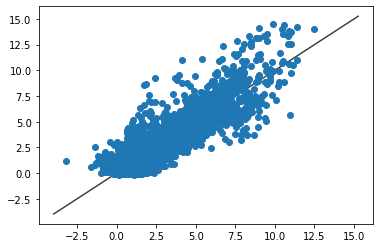

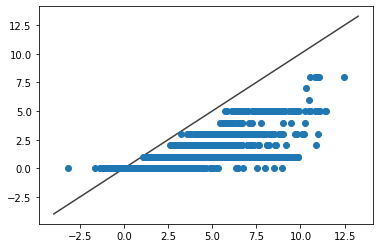

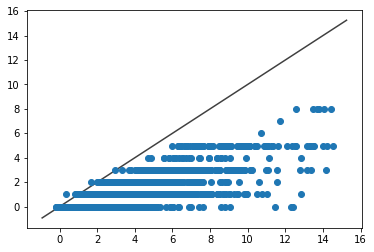

In [51]:
draw_scatter(pred_lr, pred_xgb)
draw_scatter(pred_lr, pred_rf)
draw_scatter(pred_xgb, pred_rf)

As we can see, the XGB and LR model provide generally similar classifications, whereas the RF model tends to give vastly different predictions.

# Predicting Competition Data
## Build Test Set
We want to predict block 34 so block 33 is our trianing data. We build the dataframe to contain all data we need.

In [108]:
X_test = pd.merge(test, X[X['date_block_num'] == 33], on=['shop_id', 'item_id'], how='left').drop(columns=['ID'])

In [109]:
for shop_id in X_test['shop_id'].unique():
    for column in X_test.columns:
        shop_median = X_test[X_test['shop_id'] == shop_id][column].median()
        X_test.loc[(X_test[column].isnull()) \
                   & (X_test['shop_id'] == shop_id), column] = shop_median
X_test.fillna(X_test.mean(), inplace=True)

In [116]:
X_test = X_test[X_train.columns]

## Predict

In [107]:
lr = LinearRegression()
lr.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

In [111]:
pred_lr = lr.predict(X_test.values)
pred_lr

array([ 0.46789074,  0.01593161,  0.8486228 , ...,  0.01682234,
        0.00839567,  0.03040552])

## Build Submission CSV

In [112]:
submission = pd.DataFrame()
submission['ID'] = sample_submission['ID']
submission['item_cnt_month'] = pred_lr.clip(0, 20)

submission_rounded = submission.copy()
submission_rounded['item_cnt_month'] = np.around(submission['item_cnt_month'])

submission.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.255107
std,61834.358168,0.797728
min,0.000000,0.000000
25%,53549.750000,0.028107
50%,107099.500000,0.071373
75%,160649.250000,0.230802
max,214199.000000,20.000000


In [113]:
submission.to_csv('submission.csv', index=False)
submission_rounded.to_csv('submission_rounded.csv', index=False)